In [22]:
using Flux
using JSON: JSON
using DataFrames: DataFrame
import Statistics: mean, std
using Parameters: @with_kw
using Flux: throttle, @epochs, params
using Flux.Data: DataLoader
using Plots
savepath = "/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Locomotion/analysis/CNN/dataset/data.json"

data = DataFrame(JSON.parsefile(savepath))


,V,V̇,k_1,k_2,k_3,k_4,k_5,k_6
,Any,Any,Any,Any,Any,Any,Any,Any
1,50.812,0.0,-0.0550405,-0.136502,-0.154701,-0.113021,-0.105902,-0.134835
2,50.6152,58.0636,-0.0635007,-0.145285,-0.150562,-0.110291,-0.107424,-0.142649
3,50.3968,16.0561,-0.0721468,-0.151769,-0.142906,-0.108132,-0.109688,-0.151517
4,50.147,49.2645,-0.0811853,-0.157622,-0.135952,-0.106324,-0.111996,-0.160148
5,49.8628,118.635,-0.0916386,-0.162494,-0.129559,-0.105296,-0.115373,-0.166312
6,49.5444,202.469,-0.105236,-0.162211,-0.123891,-0.105079,-0.119923,-0.172601
7,49.2572,243.245,-0.118302,-0.159438,-0.118609,-0.105096,-0.125398,-0.178541
8,49.067,216.309,-0.128934,-0.156819,-0.115111,-0.10536,-0.13053,-0.181601
9,48.9737,147.052,-0.137361,-0.154478,-0.112774,-0.105984,-0.135238,-0.180958


In [23]:
@with_kw mutable struct Options
    η::Float64 = 3e-4       # learning rate
    batchsize::Int = 64   # batch size
    epochs::Int = 5000        # number of epochs
    device::Function = gpu  # set as gpu, if gpu available
end
options = Options()

Options
  η: Float64 0.0003
  batchsize: Int64 64
  epochs: Int64 5000
  device: gpu (function of type typeof(gpu))


### normalize data

In [24]:
struct Normalizer
    μ
    σ
end

function Normalizer(x::Vector)
    return Normalizer(mean(x), std(x))
end


function normalize!(x::Vector, n::Normalizer)
    return @. (x - n.μ) / n.σ
end

normalizers = Dict(k=>Normalizer(data[:, k]) for k in names(data))
normalized_data = DataFrame(Dict(k => normalize!(data[:, k], normalizers[k]) for k in names(data)))
nothing

#### create data loader

In [26]:

inputs = filter(n->n ∉ ("V̇", "ω̇"),  names(normalized_data))
outputs = filter(n -> n ∈ ("V̇", "ω̇"), names(normalized_data))

X = Matrix(normalized_data[:, inputs])'
Y = Matrix(normalized_data[:, outputs])'

@info "Data size" size(X) size(Y) 

data_loader = DataLoader((X, Y); batchsize=options.batchsize, shuffle=true)


┌ Info: Data size
│   size(X) = (14, 35519)
│   size(Y) = (2, 35519)
└ @ Main /Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/CNN/train.ipynb:8


DataLoader{Tuple{LinearAlgebra.Adjoint{Float64, Matrix{Float64}}, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}}, Random._GLOBAL_RNG}(([-0.3673555807789519 -0.38129099365172936 … 0.18642823697749653 0.11393504807072949; -0.8574720202505218 -0.9571600374677806 … -0.20892065865102002 -0.20892065865102002; … ; 0.5598677145602157 0.5885635448058065 … -0.1373624417741412 -0.16141620750590616; -1.4270717609114312 -1.4592857986354142 … 1.0003257827375571 0.9898777136233847], [0.11544638529048547 0.5446916427690649 … -0.19640968270053294 -0.3993727165936553; -0.021003439053553258 -1.8070040394399922 … -0.11595018230277165 -0.13772743453728964]), 64, 35519, true, true, Random._GLOBAL_RNG())

#### Creat network and TRAIN

In [27]:
loss(x, y) = Flux.mse(model(x), y)

function loss_all(dataloader, model)
    l = 0f0
    for (x,y) in dataloader
        l +=  Flux.mse(model(x), y)
    end
    l/length(dataloader)
end


# optimizer
optimizer = ADAM()

ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

┌ Info: The GPU function is being called but the GPU is not accessible. 
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ Flux /Users/federicoclaudi/.julia/packages/Flux/18YZE/src/functor.jl:192
┌ Info: Created model
│   model = Chain(Dense(14 => 32, relu), Dense(32 => 32, relu), Dense(32 => 2, relu))
│   n_inputs = 14
│   n_outputs = 2
└ @ Main /Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/CNN/train.ipynb:13


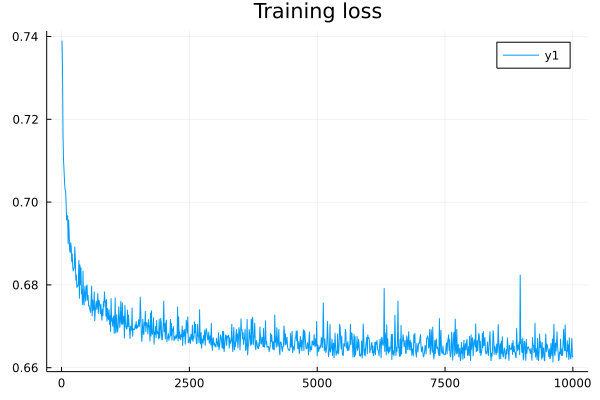

In [28]:
options = Options(η = 3e-3, epochs=10000)

# create network
n_inputs = length(names(data)) - 2
n_outputs = 2

model = Chain(
    Dense(n_inputs, 32, relu),
    Dense(32, 32, relu),
    Dense(32,  n_outputs, relu)
) |> options.device
       
@info "Created model" model n_inputs n_outputs


# train
training_loss = Float64[]
epochs = Int64[]
	for epoch in 1:options.epochs
	Flux.train!(loss, params(model), data_loader, optimizer)
	
	if epoch % 10 == 0
		# we record our training loss
		push!(epochs, epoch)
		push!(training_loss, sum(loss_all(data_loader, model)))
	end
end


# plot the results
plot(epochs, training_loss; title="Training loss")